In [ ]:
!pip install kaggle librosa soundfile matplotlib numpy
!pip install librosa soundfile numpy matplotlib tqdm
!pip install split-folders
import splitfolders
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from IPython.display import Audio
!pip install yt-dlp
import yt_dlp
import tqdm as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#Convert audio file to spectrogram
def audio_to_melspectrogram(audio_file, sr=22050, n_mels=128):
    y, sr = librosa.load(audio_file, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

Loaded audio: (661794,), Sample rate: 22050
Spectrogram shape: (128, 1293)


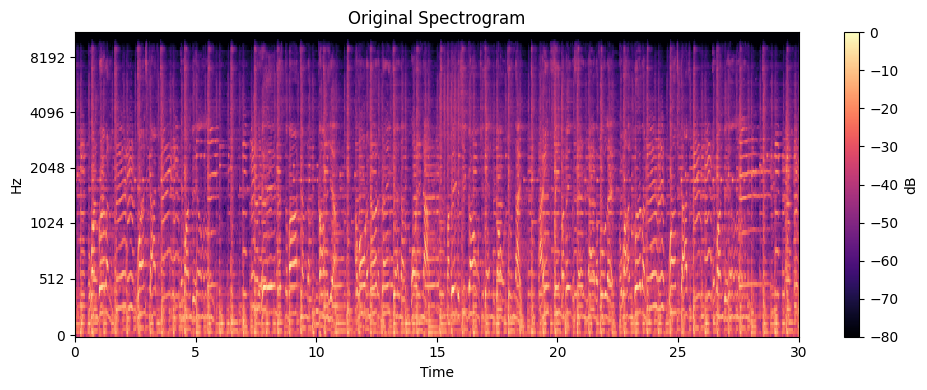

Reconstructed audio shape: (661504,)

Original Audio:


In [ ]:
# Test to see audio -> spectogram -> audio conversion

test_file = "/content/drive/MyDrive/244_project/genres/blues/blues.00000.au"

# Load with fixed sample rate for consistency
sr = 22050
y, _ = librosa.load(test_file, sr=sr)
print(f"Loaded audio: {y.shape}, Sample rate: {sr}")

# Create spectrogram with fixed parameters
n_fft = 2048
hop_length = 512
n_mels = 128

S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_dB = librosa.power_to_db(S, ref=np.max)

print(f"Spectrogram shape: {S_dB.shape}")

# Visualize original spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.title("Original Spectrogram")
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

# Reconstruct audio from spectrogram
mel_db = S_dB

# Clip extreme values
mel_db = np.clip(mel_db, -80, 0)
mel_power = librosa.db_to_power(mel_db)

# Convert mel spectrogram to audio using Griffin-Lim
audio_reconstructed = librosa.feature.inverse.mel_to_audio(
    mel_power,
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    n_iter=600
)

print(f"Reconstructed audio shape: {audio_reconstructed.shape}\n")
print("Original Audio:")
Audio(y, rate=sr)

Since yt dlp allows only one song at a time we have just kept one song however the list of songs which we tested upon are given below

https://drive.google.com/drive/folders/1ycPwVmYxcsqbaCRumEU3MCPcNyTvC_Nr


In [ ]:
!pip install yt-dlp
import yt_dlp

# Download CONTENT song
content_url = "https://youtu.be/Y_8VmzWOsgs?si=u11wyklP2S86DBTo"

ydl_opts = {
    "format": "best",
    "postprocessors": [{
        "key": "FFmpegExtractAudio",
        "preferredcodec": "wav",
        "preferredquality": "192",
    }],
    "outtmpl": "content_song.%(ext)s"
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([content_url])

# Download STYLE song
style_url = "https://youtu.be/1a5nyrMtRsk?si=uO3tJAhdbeR4GUQN"

ydl_opts = {
    "format": "best",
    "postprocessors": [{
        "key": "FFmpegExtractAudio",
        "preferredcodec": "wav",
        "preferredquality": "192",
    }],
    "outtmpl": "style_song.%(ext)s"
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([style_url])


In [ ]:
import librosa
from IPython.display import Audio
content_audio, sr = librosa.load("content_song.wav", sr=16000)
print("Content Song:")
print(f"Duration: {len(content_audio)/16000:.2f}s")
Audio(content_audio, rate=16000)

Content Song:
Duration: 17.44s


In [ ]:
import librosa
from IPython.display import Audio
style_audio, sr = librosa.load("style_song.wav", sr=16000)
print("\nStyle Song:")
print(f"Duration: {len(style_audio)/16000:.2f}s")
Audio(style_audio, rate=16000)


Style Song:
Duration: 15.09s


In [ ]:
import librosa
import numpy as np
import tensorflow as tf
from IPython.display import Audio

def load_audio_file(audio_path):
    y, sr = librosa.load(audio_path, sr=16000)
    return y

def get_mel_spectrogram(audio, sr=16000, n_mels=128, n_fft=2048, hop_length=512):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db

def mel_to_audio(mel_spec, sr=16000, n_fft=2048, hop_length=512):
    mel_db = mel_spec.numpy()
    mel_power = librosa.db_to_power(mel_db)
    audio = librosa.feature.inverse.mel_to_audio(mel_power, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return audio

# Load and prepare audio
content_audio = load_audio_file("content_song.wav")
style_audio = load_audio_file("style_song.wav")

content_mel = get_mel_spectrogram(content_audio)
style_mel = get_mel_spectrogram(style_audio)

# Ensure same dimensions
min_time = min(content_mel.shape[1], style_mel.shape[1])
content_mel = content_mel[:, :min_time]
style_mel = style_mel[:, :min_time]

print(f"Content mel shape: {content_mel.shape}")
print(f"Style mel shape: {style_mel.shape}")

def content_loss(generated, target):
    """L2 loss between spectrograms"""
    return tf.reduce_mean(tf.square(generated - target))

def style_loss_simple(generated, style):
    """Combined style loss (Spectral Flux + Mean/Std)"""
    gen_flux = tf.reduce_sum(tf.square(generated[:, 1:] - generated[:, :-1]), axis=0)
    style_flux = tf.reduce_sum(tf.square(style[:, 1:] - style[:, :-1]), axis=0)

    gen_flux_mean = tf.reduce_mean(gen_flux)
    style_flux_mean = tf.reduce_mean(style_flux)
    gen_flux_std = tf.math.reduce_std(gen_flux)
    style_flux_std = tf.math.reduce_std(style_flux)

    flux_loss = tf.square(gen_flux_mean - style_flux_mean) + tf.square(gen_flux_std - style_flux_std)

    # 2. Mean/Std - captures overall brightness/tone
    gen_mean = tf.reduce_mean(generated)
    style_mean = tf.reduce_mean(style)
    gen_std = tf.math.reduce_std(generated)
    style_std = tf.math.reduce_std(style)

    mean_std_loss = tf.square(gen_mean - style_mean) + tf.square(gen_std - style_std)

    # Combine both (equal weight)
    return 0.5 * flux_loss + 0.5 * mean_std_loss

def total_loss(generated, content_target, style_target,
               content_weight=0.1, style_weight=0.9):
    """Combined loss"""
    c_loss = content_loss(generated, content_target)
    s_loss = style_loss_simple(generated, style_target)

    total = content_weight * c_loss + style_weight * s_loss
    return total, c_loss, s_loss


# Training setup
content_mel_const = tf.constant(content_mel, dtype=tf.float32)
style_mel_const = tf.constant(style_mel, dtype=tf.float32)

generated_mel = tf.Variable(content_mel, dtype=tf.float32)

optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Lists to store loss values during training
epochs_list = []
total_loss_list = []
content_loss_list = []
style_loss_list = []

# Training loop
epochs = 300

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss = total_loss(
            generated_mel,
            content_mel_const,
            style_mel_const,
            content_weight=0.05,
            style_weight=0.95
        )

    # Store loss values every 20 epochs
    if epoch % 20 == 0:
        epochs_list.append(epoch)
        total_loss_list.append(loss.numpy())
        content_loss_list.append(c_loss.numpy())
        style_loss_list.append(s_loss.numpy())
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}, Content: {c_loss.numpy():.4f}, Style: {s_loss.numpy():.4f}")

    grad = tape.gradient(loss, generated_mel)

    # Update
    optimizer.apply_gradients([(grad, generated_mel)])

    # Clip values
    generated_mel.assign(tf.clip_by_value(generated_mel, -80, 0))

# Convert to audio
audio = mel_to_audio(generated_mel)
audio = audio / (np.max(np.abs(audio)) + 1e-8)

print("\nGenerated Audio:")
Audio(audio, rate=16000)

Content mel shape: (128, 559)
Style mel shape: (128, 559)
Epoch 0, Loss: 7024815.0000, Content: 0.0000, Style: 7394542.0000
Epoch 20, Loss: 6536938.0000, Content: 0.0379, Style: 6880987.5000
Epoch 40, Loss: 6007350.5000, Content: 0.1496, Style: 6323527.0000
Epoch 60, Loss: 5432333.0000, Content: 0.3363, Style: 5718245.5000
Epoch 80, Loss: 4816974.0000, Content: 0.5997, Style: 5070499.0000
Epoch 100, Loss: 4176186.7500, Content: 0.9378, Style: 4395986.0000
Epoch 120, Loss: 3533141.2500, Content: 1.3432, Style: 3719096.0000
Epoch 140, Loss: 2917426.0000, Content: 1.8041, Style: 3070974.7500
Epoch 160, Loss: 2359790.5000, Content: 2.3035, Style: 2483990.0000
Epoch 180, Loss: 1886730.2500, Content: 2.8189, Style: 1986031.7500
Epoch 200, Loss: 1512916.8750, Content: 3.3246, Style: 1592544.0000
Epoch 220, Loss: 1237747.8750, Content: 3.7939, Style: 1302892.2500
Epoch 240, Loss: 1045653.0625, Content: 4.2043, Style: 1100687.2500
Epoch 260, Loss: 912919.6250, Content: 4.5439, Style: 960967.750

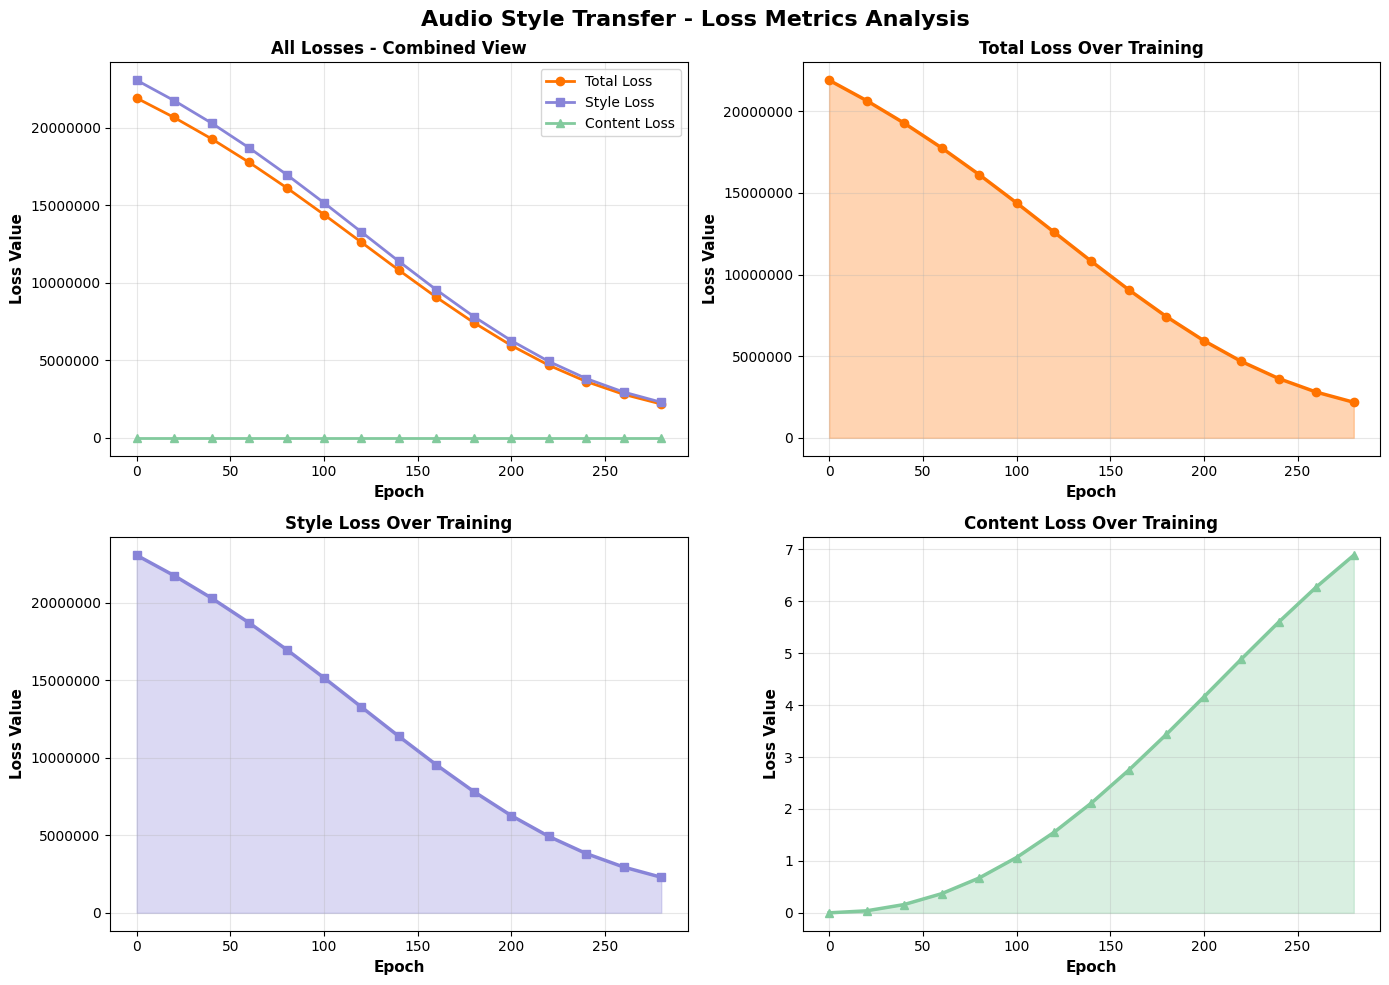

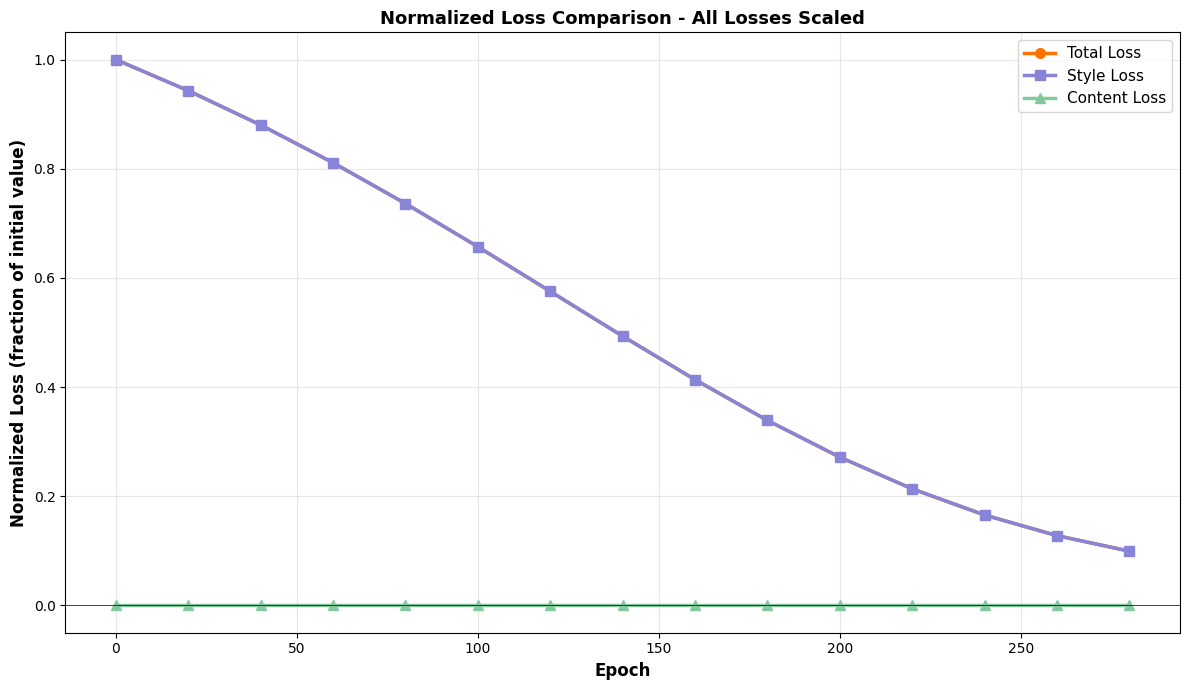

LOSS METRICS SUMMARY

Total Loss:
  Initial (Epoch 0):  21,906,846
  Final (Epoch 280):  2,178,778
  Reduction:          90.05%

Style Loss:
  Initial (Epoch 0):  23,059,838
  Final (Epoch 280):  2,293,451
  Reduction:          90.05%

Content Loss:
  Initial (Epoch 0):  0.0000
  Final (Epoch 280):  6.8850
  Change:             6.8850 (increase)

Ratio of Style to Content Loss:
  Initial: 2,305,983,778,914,304x
  Final:   333,111x


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Audio Style Transfer - Loss Metrics Analysis', fontsize=16, fontweight='bold')

# Plot 1: All three losses on same graph
ax1 = axes[0, 0]
ax1.plot(epochs_list, total_loss_list, marker='o', linewidth=2, label='Total Loss', color='#ff7300')
ax1.plot(epochs_list, style_loss_list, marker='s', linewidth=2, label='Style Loss', color='#8884d8')
ax1.plot(epochs_list, content_loss_list, marker='^', linewidth=2, label='Content Loss', color='#82ca9d')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
ax1.set_title('All Losses - Combined View', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# Plot 2: Total Loss only
ax2 = axes[0, 1]
ax2.plot(epochs_list, total_loss_list, marker='o', linewidth=2.5, color='#ff7300', markersize=6)
ax2.fill_between(epochs_list, total_loss_list, alpha=0.3, color='#ff7300')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
ax2.set_title('Total Loss Over Training', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='plain', axis='y')

# Plot 3: Style Loss only
ax3 = axes[1, 0]
ax3.plot(epochs_list, style_loss_list, marker='s', linewidth=2.5, color='#8884d8', markersize=6)
ax3.fill_between(epochs_list, style_loss_list, alpha=0.3, color='#8884d8')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
ax3.set_title('Style Loss Over Training', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.ticklabel_format(style='plain', axis='y')

# Plot 4: Content Loss only
ax4 = axes[1, 1]
ax4.plot(epochs_list, content_loss_list, marker='^', linewidth=2.5, color='#82ca9d', markersize=6)
ax4.fill_between(epochs_list, content_loss_list, alpha=0.3, color='#82ca9d')
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Loss Value', fontsize=11, fontweight='bold')
ax4.set_title('Content Loss Over Training', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Optional: Create separate figure for normalized comparison
fig2, ax = plt.subplots(figsize=(12, 7))

# Normalize losses for comparison (divide by initial value)
total_norm = [loss / total_loss_list[0] for loss in total_loss_list]
style_norm = [loss / style_loss_list[0] for loss in style_loss_list]
content_norm = [loss / content_loss_list[0] if content_loss_list[0] != 0 else 0 for loss in content_loss_list]

ax.plot(epochs_list, total_norm, marker='o', linewidth=2.5, label='Total Loss', color='#ff7300', markersize=7)
ax.plot(epochs_list, style_norm, marker='s', linewidth=2.5, label='Style Loss', color='#8884d8', markersize=7)
ax.plot(epochs_list, content_norm, marker='^', linewidth=2.5, label='Content Loss', color='#82ca9d', markersize=7)
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Loss (fraction of initial value)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Loss Comparison - All Losses Scaled', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 60)
print("LOSS METRICS SUMMARY")
print("=" * 60)
print(f"\nTotal Loss:")
print(f"  Initial (Epoch 0):  {total_loss_list[0]:,.0f}")
print(f"  Final (Epoch {epochs_list[-1]}):  {total_loss_list[-1]:,.0f}")
print(f"  Reduction:          {((total_loss_list[0] - total_loss_list[-1]) / total_loss_list[0] * 100):.2f}%")

print(f"\nStyle Loss:")
print(f"  Initial (Epoch 0):  {style_loss_list[0]:,.0f}")
print(f"  Final (Epoch {epochs_list[-1]}):  {style_loss_list[-1]:,.0f}")
print(f"  Reduction:          {((style_loss_list[0] - style_loss_list[-1]) / style_loss_list[0] * 100):.2f}%")

print(f"\nContent Loss:")
print(f"  Initial (Epoch 0):  {content_loss_list[0]:.4f}")
print(f"  Final (Epoch {epochs_list[-1]}):  {content_loss_list[-1]:.4f}")
print(f"  Change:             {content_loss_list[-1] - content_loss_list[0]:.4f} (increase)")

print(f"\nRatio of Style to Content Loss:")
print(f"  Initial: {style_loss_list[0] / (content_loss_list[0] + 1e-8):,.0f}x")
print(f"  Final:   {style_loss_list[-1] / content_loss_list[-1]:,.0f}x")

print("=" * 60)

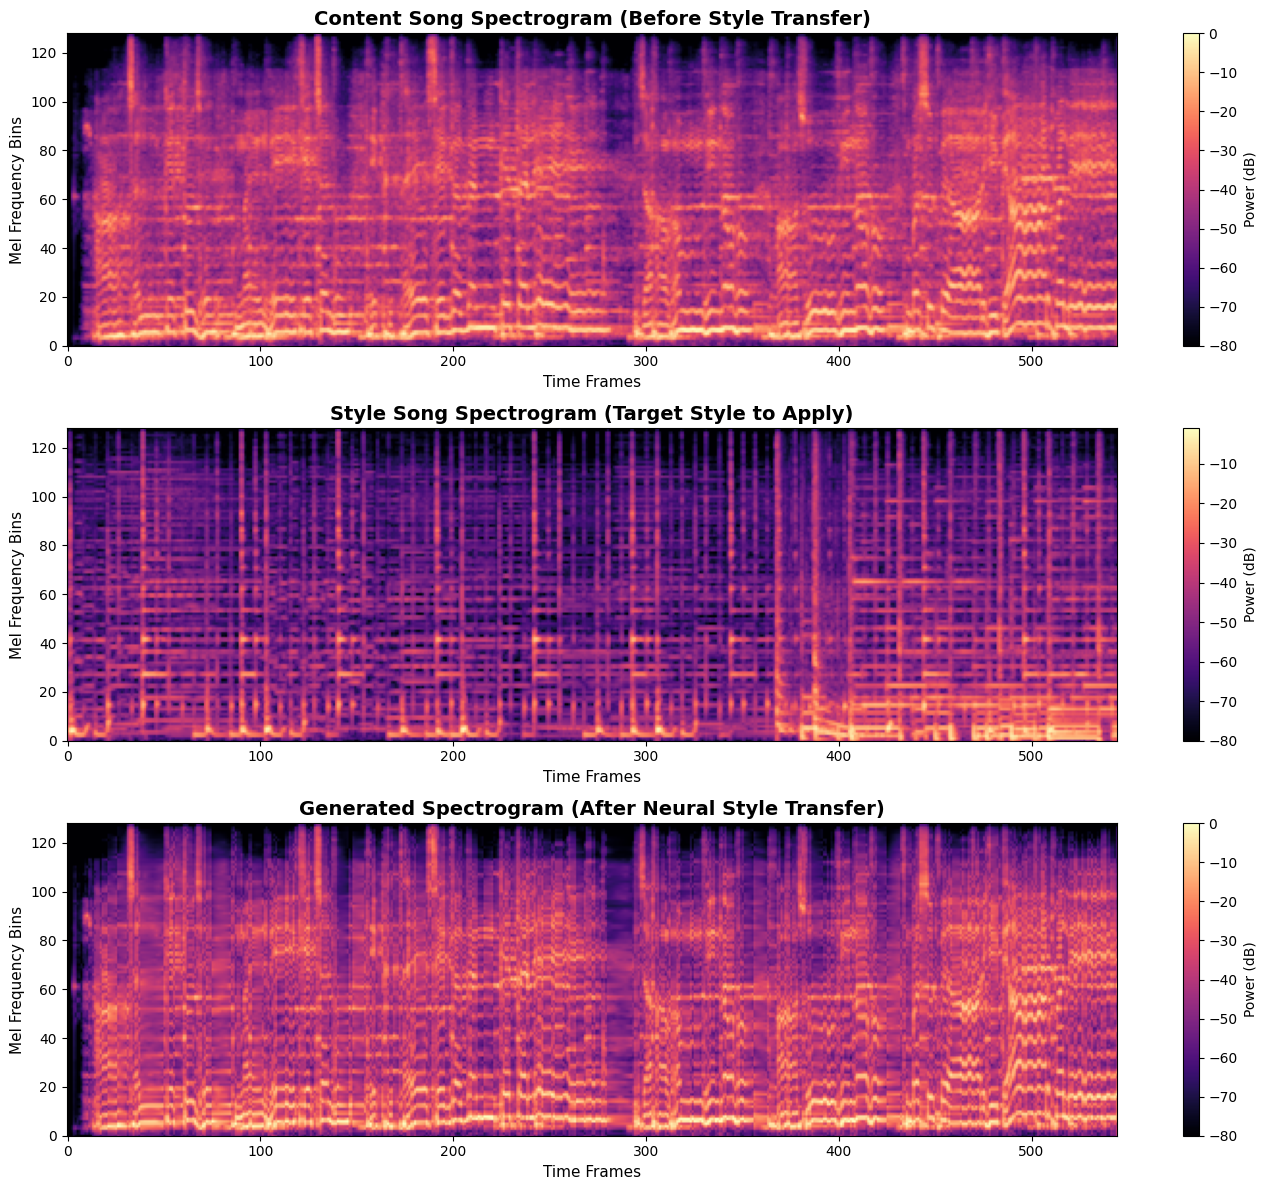

SPECTROGRAM COMPARISON STATISTICS

Content Spectrogram (Before):
  Shape: (128, 545)
  Min dB: -80.00
  Max dB: 0.00
  Mean dB: -41.94
  Std Dev: 14.08

Style Spectrogram (Reference):
  Shape: (128, 545)
  Min dB: -80.00
  Max dB: -1.01
  Mean dB: -52.82
  Std Dev: 13.32

Generated Spectrogram (After Style Transfer):
  Shape: (128, 545)
  Min dB: -80.00
  Max dB: 0.00
  Mean dB: -41.92
  Std Dev: 14.53

Difference Analysis:
  Content vs Generated (MSE): 7.42
  Style vs Generated (MSE): 346.97
  Ratio (style/content): 46.7642
  (Lower ratio means more similar to content, higher means more similar to style)
  → Generated is MORE similar to STYLE (46.76x more)


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Audio

# Trim all spectrograms to same size (content_mel shape was trimmed during training)
min_time = content_mel.shape[1]  # This is 545 from your training

# Content Spectrogram (Before) - trim to match
content_display = get_mel_spectrogram(content_audio)[:, :min_time]

# Style Spectrogram (Reference) - trim to match
style_display = get_mel_spectrogram(style_audio)[:, :min_time]

# Generated Spectrogram (After Style Transfer) - already trimmed
generated_display = generated_mel.numpy()

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Content Spectrogram (Before)
im1 = axes[0].imshow(content_display, aspect='auto', origin='lower', cmap='magma')
axes[0].set_title('Content Song Spectrogram (Before Style Transfer)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Frames', fontsize=11)
axes[0].set_ylabel('Mel Frequency Bins', fontsize=11)
axes[0].set_ylim(0, 128)
cbar1 = plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# Plot 2: Style Spectrogram (Reference)
im2 = axes[1].imshow(style_display, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Style Song Spectrogram (Target Style to Apply)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Frames', fontsize=11)
axes[1].set_ylabel('Mel Frequency Bins', fontsize=11)
axes[1].set_ylim(0, 128)
cbar2 = plt.colorbar(im2, ax=axes[1], label='Power (dB)')

# Plot 3: Generated Spectrogram (After Style Transfer)
im3 = axes[2].imshow(generated_display, aspect='auto', origin='lower', cmap='magma')
axes[2].set_title('Generated Spectrogram (After Neural Style Transfer)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Frames', fontsize=11)
axes[2].set_ylabel('Mel Frequency Bins', fontsize=11)
axes[2].set_ylim(0, 128)
cbar3 = plt.colorbar(im3, ax=axes[2], label='Power (dB)')

plt.tight_layout()
plt.show()

# Print statistics about spectrograms
print("=" * 70)
print("SPECTROGRAM COMPARISON STATISTICS")
print("=" * 70)

print("\nContent Spectrogram (Before):")
print(f" Shape: {content_display.shape}")
print(f" Min dB: {np.min(content_display):.2f}")
print(f" Max dB: {np.max(content_display):.2f}")
print(f" Mean dB: {np.mean(content_display):.2f}")
print(f" Std Dev: {np.std(content_display):.2f}")

print("\nStyle Spectrogram (Reference):")
print(f" Shape: {style_display.shape}")
print(f" Min dB: {np.min(style_display):.2f}")
print(f" Max dB: {np.max(style_display):.2f}")
print(f" Mean dB: {np.mean(style_display):.2f}")
print(f" Std Dev: {np.std(style_display):.2f}")

print("\nGenerated Spectrogram (After Style Transfer):")
print(f" Shape: {generated_display.shape}")
print(f" Min dB: {np.min(generated_display):.2f}")
print(f" Max dB: {np.max(generated_display):.2f}")
print(f" Mean dB: {np.mean(generated_display):.2f}")
print(f" Std Dev: {np.std(generated_display):.2f}")

# Calculate differences (all same size now)
print("\nDifference Analysis:")
content_generated_diff = np.mean((generated_display - content_display)**2)
style_generated_diff = np.mean((generated_display - style_display)**2)
print(f" Content vs Generated (MSE): {content_generated_diff:.2f}")
print(f" Style vs Generated (MSE): {style_generated_diff:.2f}")
if content_generated_diff > 0:
    ratio = style_generated_diff / content_generated_diff
    print(f"Ratio (style/content): {ratio:.4f}")
    print(f"(Lower ratio means more similar to content, higher means more similar to style)")
    if ratio > 1:
        print(f"  → Generated is MORE similar to STYLE ({ratio:.2f}x more)")
    else:
        print(f"  → Generated is MORE similar to CONTENT ({1/ratio:.2f}x more)")

print("=" * 70)

In [ ]:
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

print("Loading audio files...")
content_audio, sr_content = librosa.load("content_song.wav", sr=16000)
style_audio, sr_style = librosa.load("style_song.wav", sr=16000)

print(f"Content: {len(content_audio)/16000:.2f}s, Style: {len(style_audio)/16000:.2f}s")

# Get spectrograms
content_mel = librosa.feature.melspectrogram(y=content_audio, sr=16000, n_mels=128)
style_mel = librosa.feature.melspectrogram(y=style_audio, sr=16000, n_mels=128)

content_mel_db = librosa.power_to_db(content_mel, ref=np.max)
style_mel_db = librosa.power_to_db(style_mel, ref=np.max)

def spectrogram_to_audio(mel_spec, sr=16000, n_fft=2048, hop_length=512):
    """Convert spectrogram back to audio"""
    mel_power = librosa.db_to_power(mel_spec)
    audio = librosa.feature.inverse.mel_to_audio(
        mel_power, sr=sr, n_fft=n_fft, hop_length=hop_length
    )
    return audio

# Ensure same dimensions
min_time = min(content_mel_db.shape[1], style_mel_db.shape[1])
content_mel_db = content_mel_db[:, :min_time]
style_mel_db = style_mel_db[:, :min_time]

Loading audio files...
Content: 17.44s, Style: 15.09s


In [ ]:
generated_audio = np.random.randn(128, min_time) * 20 - 40
generated_audio = np.clip(generated_audio, -80, 0)  # Clip to valid dB range

audio = spectrogram_to_audio(generated_audio)
audio = audio / (np.max(np.abs(audio)) + 1e-8)

Audio(audio, rate=16000)